In [828]:
import collections
import glob
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import random
from collections import defaultdict

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from utils_parallel_syn_gradient import *
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})/

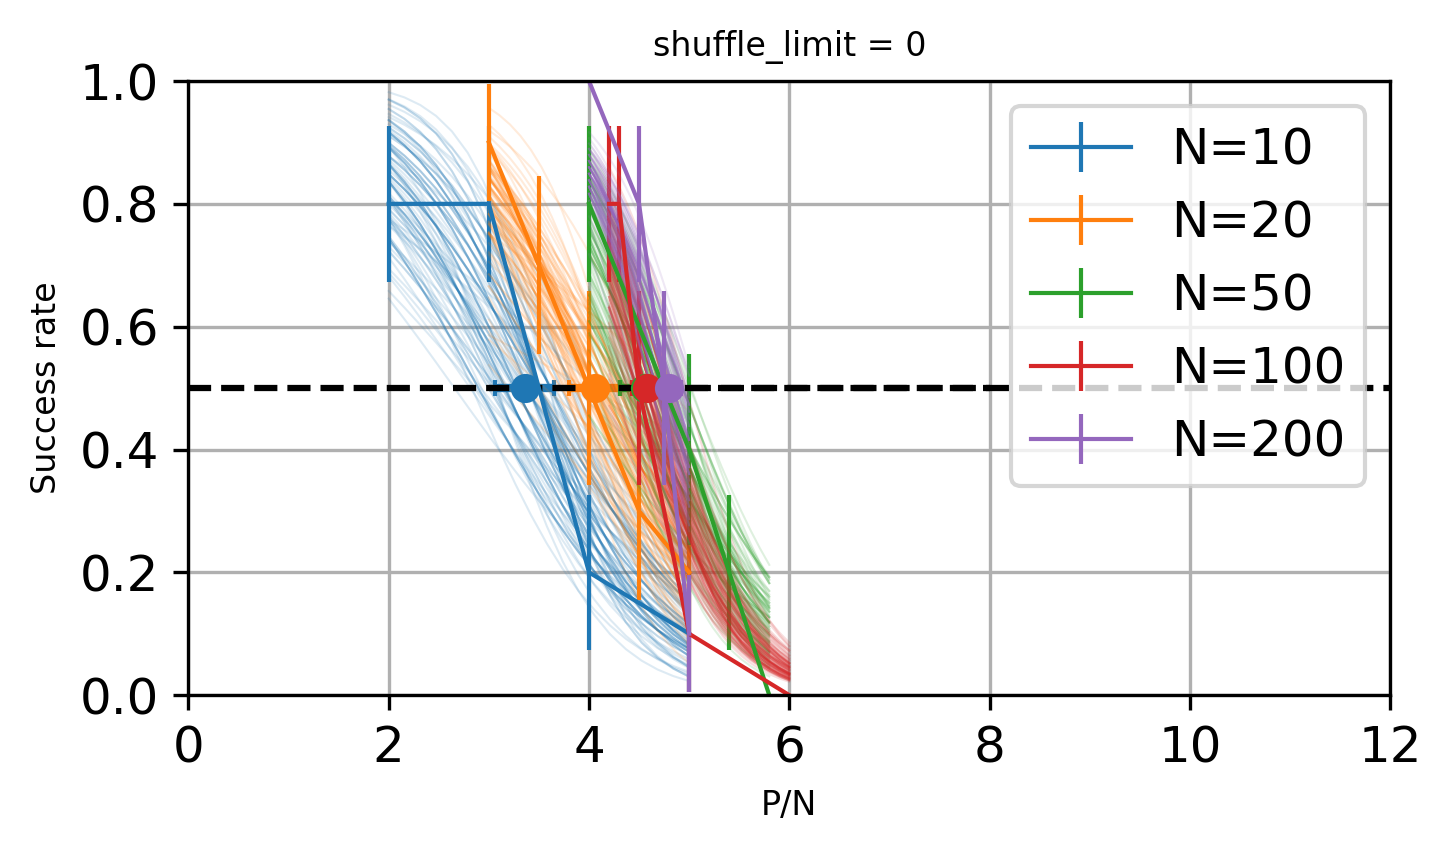

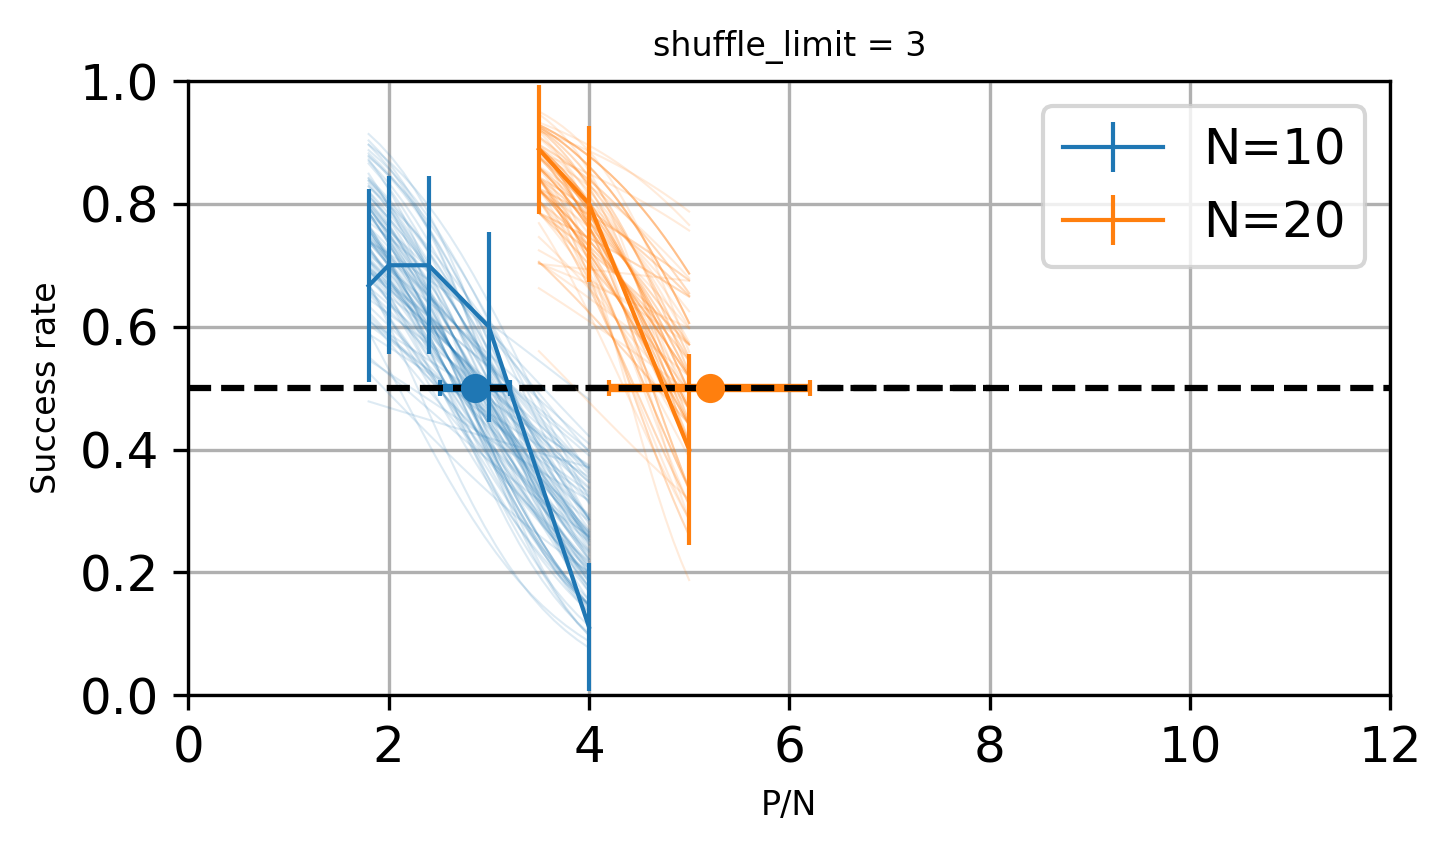

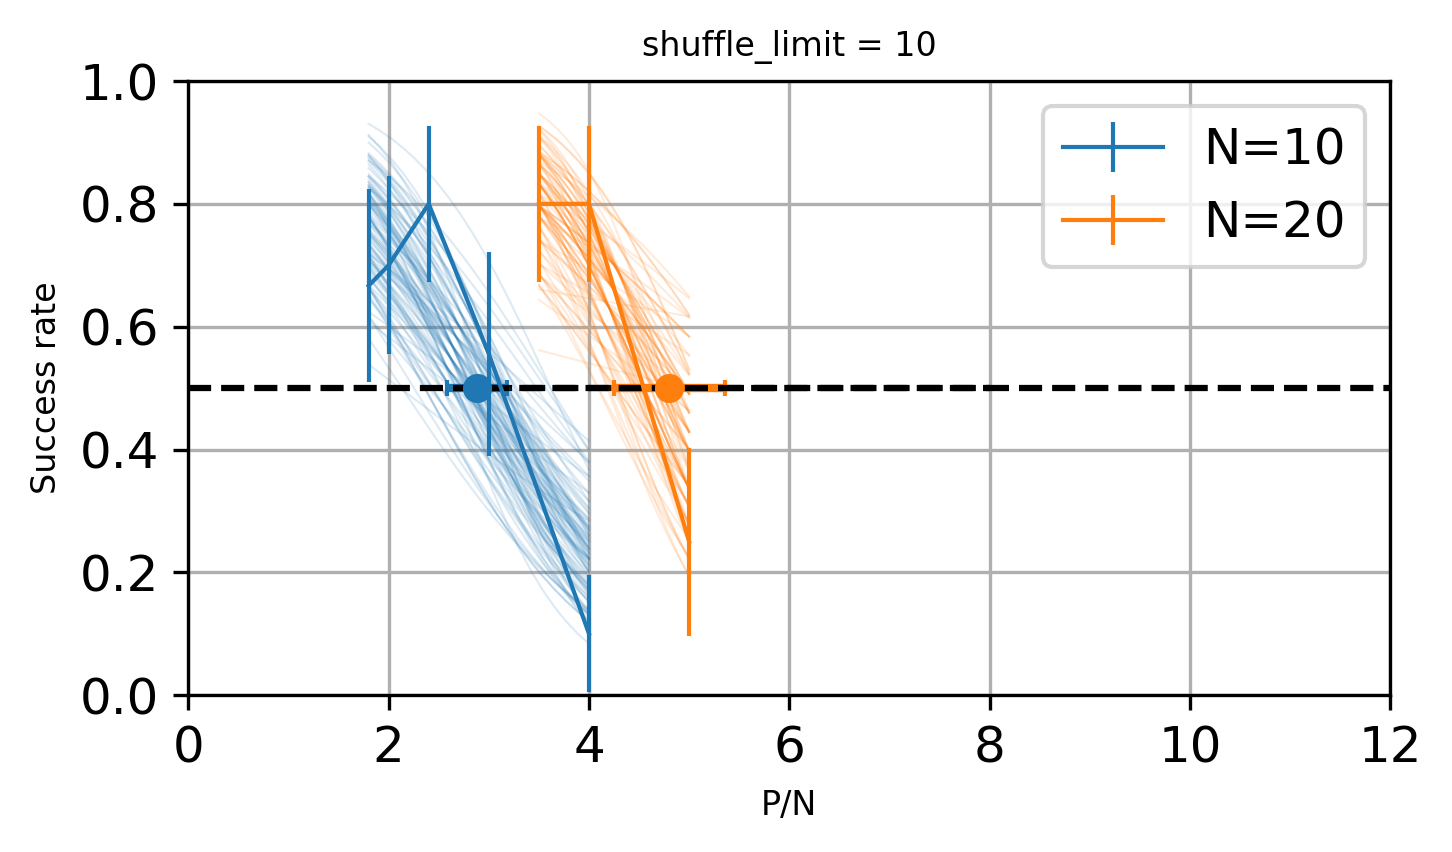

In [829]:
all_count_trial_dict = defaultdict(dict)
all_capacity_dict = defaultdict(dict)
for shuffle_limit in [0, 3, 10]:
    experi = {}
    allN = set()
    allM = set()

    for N in [10, 20, 50, 100, 200, 500]:
        if shuffle_limit == 0:
            path = glob.glob(
                "./N_" + str(N) + "_png/*seed_[0-9]*_shuffle_False" + ".png"
            ) + glob.glob(
                "./N_" + str(N) + "_png/*seed_[0-9]*_shuffle_False" + "_true.png"
            )
        else:
            path = glob.glob(
                "./N_"
                + str(N)
                + "_png/*seed_[0-9]*_shuffle_True_shuffle_limit_"
                + str(shuffle_limit)
                + ".png"
            ) + glob.glob(
                "./N_"
                + str(N)
                + "_png/*seed_[0-9]*_shuffle_True_shuffle_limit_"
                + str(shuffle_limit)
                + "_true.png"
            )

        for p_ in path:
            params = p_.split("/")[-1].replace(".png", "").split("_")

            N_, M_, P_, seed_ = (
                int(params[1]),
                int(params[3]),
                int(params[5]),
                int(params[7]),
            )
            if M_ not in [5]:
                continue
            if (N_, M_) not in experi:
                experi[(N_, M_)] = {}
            if P_ not in experi[(N_, M_)]:
                experi[(N_, M_)][P_] = np.ones((20,), dtype=int) * np.nan

            if experi[(N_, M_)][P_][seed_] > 0:
                continue
            else:
                experi[(N_, M_)][P_][seed_] = int(params[-1] == "true")

            if N_ not in allN:
                allN.add(N_)
            if M_ not in allM:
                allM.add(M_)

        for N_, M_ in experi:
            for P_ in experi[(N_, M_)]:
                experi[(N_, M_)][P_] = experi[(N_, M_)][P_][
                    ~np.isnan(experi[(N_, M_)][P_])
                ]
            experi[(N_, M_)] = collections.OrderedDict(sorted(experi[(N_, M_)].items()))

    arrayN = np.array(sorted(list(allN)))
    arrayM = np.array(sorted(list(allM)))
    countTrialDict = {}
    for N in arrayN:
        for M in arrayM:
            if (N, M) in experi:
                countTrial = []
                for k in experi[(N, M)]:
                    countTrial.append(
                        (
                            k,
                            k / N,
                            len(experi[(N, M)][k]),
                            sum(experi[(N, M)][k]) / len(experi[(N, M)][k]),
                        )
                    )
                countTrialDict[(N, M)] = countTrial
            else:
                countTrialDict[(N, M)] = []

    for N, M in countTrialDict:
        if M != 10:
            continue
        print("N, M:", N, M, " P, alpha, count, rate: ")
        print(countTrialDict[(N, M)])
        print("----")
    all_count_trial_dict[shuffle_limit] = countTrialDict
    plt.figure(figsize=(5, 3), dpi=300)
    plt.plot([3, 14], [0.5, 0.5], "k--")
    c = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
    ]

    arrayN = np.array(sorted(list(allN)))
    arrayM = np.array(sorted(list(allM)))
    capacity = {}
    for count, (N, M) in enumerate(experi):
        if M not in [3, 5, 10]:
            continue
        if M not in capacity:
            capacity[M] = []

        sample = 100
        psedoC = []
        for i in range(sample):
            psedoX = []
            psedoY = []

            for P in experi[(N, M)]:
                psedoX += [P / N] * len(experi[(N, M)][P])
                psedoY += random.choices(experi[(N, M)][P], k=len(experi[(N, M)][P]))
            if min(psedoY) == max(psedoY):
                continue
            clf = LogisticRegression().fit(
                np.array(psedoX).reshape(-1, 1), np.array(psedoY)
            )
            newX = np.linspace(
                min(experi[(N, M)].keys()) / N, max(experi[(N, M)].keys()) / N, 20
            )
            if np.abs(-clf.intercept_[0] / clf.coef_[0][0]) > 20:
                continue
            psedoC.append(-clf.intercept_[0] / clf.coef_[0][0])

            probs = clf.predict_proba(newX.reshape(-1, 1))

            plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
            plt.plot(
                newX,
                probs[:, 1],
                alpha=0.15,
                linewidth=0.5,
                color=c[np.where(arrayN == N)[0][0]],
            )

        capacity[M].append(
            [N, M, np.nanmean(np.array(psedoC)), np.nanstd(np.array(psedoC))]
        )

        plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
        plt.errorbar(
            np.array(list(experi[(N, M)].keys())) / N,
            [np.mean(np.array(experi[(N, M)][P])) for P in experi[(N, M)]],
            yerr=[
                np.std(np.array(experi[(N, M)][P])) / np.sqrt(len(experi[(N, M)][P]))
                for P in experi[(N, M)]
            ],
            label="N=" + str(N),
            linewidth=1,
            color=c[np.where(arrayN == N)[0][0]],
        )

        plt.errorbar(
            [np.array(psedoC).mean()],
            [0.5],
            xerr=np.array(psedoC).std(),
            fmt="o",
            linewidth=2,
            capsize=2,
            color=c[np.where(arrayN == N)[0][0]],
        )
    for i in range(arrayM.size):
        plt.subplot(arrayM.size, 1, i + 1)
        plt.title("shuffle_limit = " + str(shuffle_limit), fontsize=8)
        plt.legend()
        plt.xlim([0, 12])
        plt.ylim([0, 1])
        plt.plot([0, 8], [0.5, 0.5], "k--")
        plt.grid()
        plt.xlabel("P/N", fontsize=8)
        plt.ylabel("Success rate", fontsize=8)
    for M in capacity:
        capacity[M] = np.array(capacity[M])
    capacity = collections.OrderedDict(sorted(capacity.items()))

    plt.tight_layout()

    plt.savefig("success_rate.pdf")
    plt.show()

    all_capacity_dict[shuffle_limit] = capacity


In [830]:
all_count_trial_dict
# all_capacity_dict .
# n_repeat = 50 ;{(100, 5): [(400, 4.0, 10, 0.6), (450, 4.5, 10, 0.1), (500, 5.0, 10, 0.0)]}

defaultdict(dict,
            {0: {(10, 5): [(20, 2.0, 10, 0.8),
               (30, 3.0, 10, 0.8),
               (40, 4.0, 10, 0.2),
               (50, 5.0, 10, 0.1)],
              (20, 5): [(60, 3.0, 10, 0.9),
               (70, 3.5, 10, 0.7),
               (80, 4.0, 10, 0.5),
               (90, 4.5, 10, 0.3),
               (100, 5.0, 10, 0.2)],
              (50, 5): [(200, 4.0, 10, 0.8),
               (250, 5.0, 10, 0.4),
               (270, 5.4, 10, 0.2),
               (290, 5.8, 10, 0.0)],
              (100, 5): [(420, 4.2, 10, 0.8),
               (430, 4.3, 10, 0.8),
               (450, 4.5, 10, 0.5),
               (500, 5.0, 10, 0.1),
               (600, 6.0, 10, 0.0)],
              (200, 5): [(800, 4.0, 10, 1.0),
               (900, 4.5, 10, 0.8),
               (950, 4.75, 10, 0.5),
               (1000, 5.0, 10, 0.1)]},
             3: {(10, 5): [(18, 1.8, 9, 0.6666666666666666),
               (20, 2.0, 10, 0.7),
               (24, 2.4, 10, 0.7),
         

In [831]:
arrayM

array([5])

# plot final result

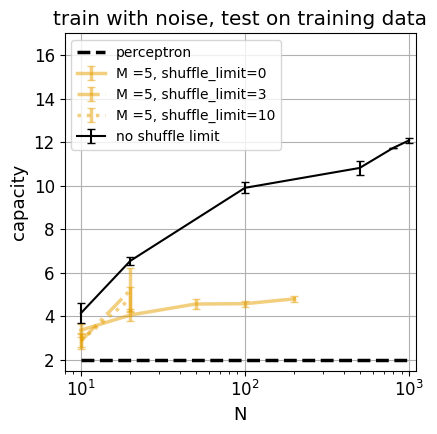

In [832]:
ax = plt.figure(figsize=(4.5, 4.5))
color = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
line = ["-", "-.", ":"]
# plt.errorbar(capacity1[:, 0], capacity1[:, 2], yerr = capacity1[:, 3], capsize = 2, color = 'k', label = 'M = 5')
for i_repeat, k in enumerate(all_capacity_dict):
    capacity = all_capacity_dict[k]
    for i, M in enumerate(capacity):
        x, y, yerr = capacity[M][:, 0], capacity[M][:, 2], capacity[M][:, 3]
        plt.errorbar(
            x[~np.isnan(y)],
            y[~np.isnan(y)],
            yerr=yerr[~np.isnan(y)],
            capsize=3,
            color=color[i],
            label="M =" + str(M) + ", shuffle_limit=" + str(k),
            linestyle=line[i_repeat],
            linewidth=2.5,
            alpha=0.5,
        )
    # plt.errorbar(
    #     capacityms[:, 0],
    #     capacityms[:, 1],
    #     yerr=capacityms[:, 2],
    #     capsize=3,
    #     color="r",
    #     label="unlimited",
    #     linewidth=3,
    # )
# load capacity from normal parallel synapse model
with open("capacity_restricted_model.pkl", "rb") as f:
    capacity_no_limit = pickle.load(f)
capacity_no_limit = capacity_no_limit[5]
plt.errorbar(
    capacity_no_limit[:, 0],
    capacity_no_limit[:, 2],
    yerr=capacity_no_limit[:, 3],
    capsize=3,
    color="k",
    label="no shuffle limit",
)
plt.plot(
    np.logspace(1, 3, 5), np.ones((5,)) * 2, "k--", linewidth=2.5, label="perceptron"
)
plt.xscale("log")
# plt.yscale('log')
# plt.xticks([0 + i*100 for i in range(12)])
plt.grid()

plt.xlabel("N", fontsize=13)
plt.ylabel("capacity", fontsize=13)
plt.ylim([1.5, 17])

plt.xlim([-10, 1.1e3])
plt.legend(ncol=1, prop={"size": 10})
# plt.grid()
plt.title("train with noise, test on training data")
plt.tight_layout()


plt.savefig("capacity_limited_shuffle.pdf")

# plot activation histogram

In [833]:
from parallel_synapse_gradient import *


class args:
    def init(self):
        N = 0
        M = 0
        seed = 0
        P = 0


args.N, args.M, args.seed, args.P = 50, 5, 0, 400
allActv = []
# for args.seed in range(10):
model_params = {
    "N": args.N,  # input dimension
    "M": args.M,  # parallel synapse number
    "seed": args.seed,
    "device": torch.device("cpu"),
}
train_params = {
    "margin": 0.1,  # only applied when 'loss' is hinge
    "threslr": 1e-6,
    "adamlr": 0.003,
    "minAmpli": 1e-1,
    "Nepoch": 160000,
    "P": args.P,
    "maxRecord": 4000,
    "downSample": 100,
    "NthresPool": int(args.P / 2),
}
shuffle_limit = 10
path = ""
folder = "./N_" + str(model_params["N"])
# folder = './monsyn4'
#
path += (
    "N_"
    + str(model_params["N"])
    + "_M_"
    + str(model_params["M"])
    + "_P_"
    + str(train_params["P"])
    + "_seed_"
    + str(model_params["seed"])
    + "_shuffle_True_shuffle_limit_"
    + str(shuffle_limit)
)

model = ParallelSyn(model_params)


state_dict = torch.load(folder + "/" + path, map_location=model_params["device"])
model.load_state_dict(state_dict)


FileNotFoundError: [Errno 2] No such file or directory: './N_50/N_50_M_5_P_400_seed_0_shuffle_True_shuffle_limit_10'

In [ ]:
def plot_activation(model, n, file):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]

    nX = 100
    """
    plot the staircase functions
    """
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim)
    )

    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()

    x = x[:, 0]
    x = x.numpy()
    plt.rcParams.update({"font.size": 12})
    plt.figure(figsize=(4.5, 4.5))
    plt.plot(x, actv[:, :n], linestyle="-", alpha=0.8)
    plt.xlabel("input")
    plt.ylabel("arbitrary unit")
    plt.title("aggregate synaptic function")
    plt.tight_layout()
    plt.show()

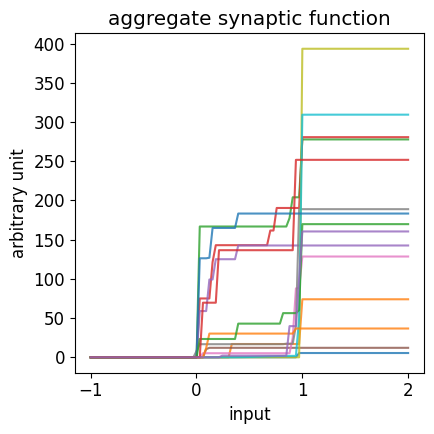

In [ ]:
plot_activation(model, 15, "")


In [ ]:
def ampli_hist(model):
    """
    plot the amplitude histogram of the synaptic function

    method 0:
        plot the histogram of the nonzero a**2
    method 1:
        local variation of the amplitude
    method 2:
        starting from zero, get slopes

    """

    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    # method 0
    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)
    plt.figure(figsize=(9.0, 3.0), dpi=200)
    plt.subplot(1, 3, 1)
    plt.hist(ampli.ravel(), bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    # plt.title("a_{ij}^2")
    # plt.tight_layout()
    # plt.savefig("a_squared_log_scale.pdf")
    # plt.title("amplitude histogram")

    # method 1, local variation of the amplitude
    nX = 100
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim)
    )
    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()
    x = x[:, 0]
    x = x.numpy()
    actv_local_slope = np.diff(actv, axis=0).T / np.diff(x).ravel()
    actv_local_slope = actv_local_slope[
        ~np.isnan(actv_local_slope) & (actv_local_slope > 0)
    ]
    plt.subplot(1, 3, 2)
    plt.hist(actv_local_slope, bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Local slope")
    plt.ylabel("Frequency")

    actv_global_slope = (actv[1:, :] - actv[0, :]).T / (x[1:] - x[0]).ravel()
    actv_global_slope = actv_global_slope[
        ~np.isnan(actv_global_slope) & (actv_global_slope > 0)
    ]

    plt.subplot(1, 3, 3)
    plt.hist(actv_global_slope, bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Global slope")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


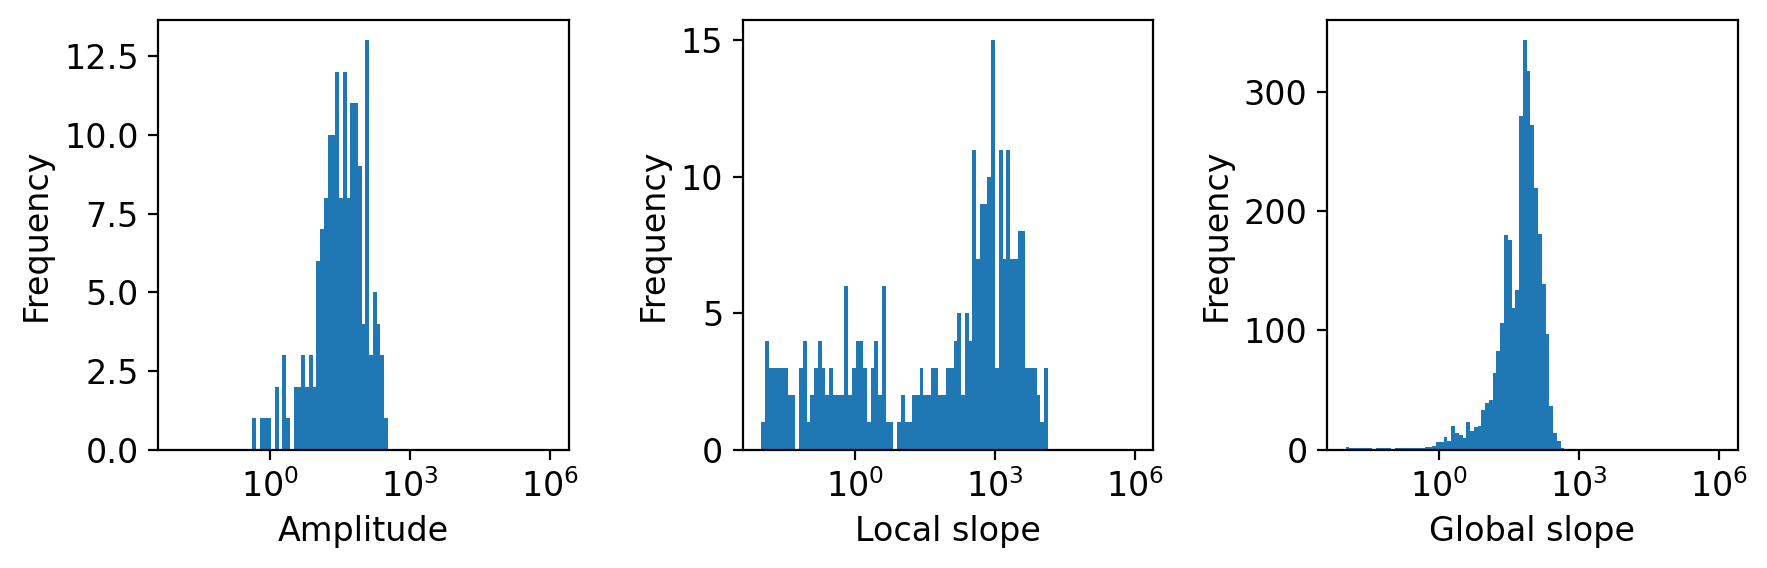

In [ ]:
ampli_hist(model)

In [ ]:
def thres_ampli(model):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)
    plt.figure(figsize=(9, 3.0))
    plt.subplot(1, 3, 1)
    plt.hist(ampli.ravel(), bins=100)
    plt.xlabel("amplitude")
    plt.ylabel("frequency")
    plt.title("amplitude histogram")
    plt.subplot(1, 3, 2)
    plt.hist(thres.ravel(), bins=50)
    plt.xlabel("threshold")
    plt.ylabel("frequency")
    plt.title("threshold histogram")

    plt.subplot(1, 3, 3)

    plt.errorbar(thresBin[1:], allAmpli[:, 0], yerr=allAmpli[:, 1])
    plt.xlabel("threshold")
    plt.ylabel("amplitude ")
    plt.title("amplitude vs threshold")
    plt.tight_layout()
    plt.show()

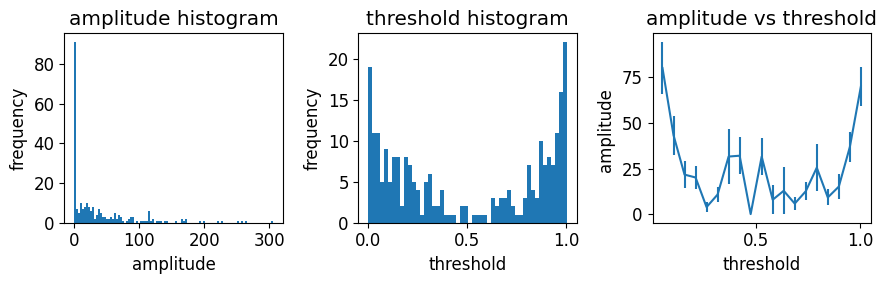

In [ ]:
thres_ampli(model)

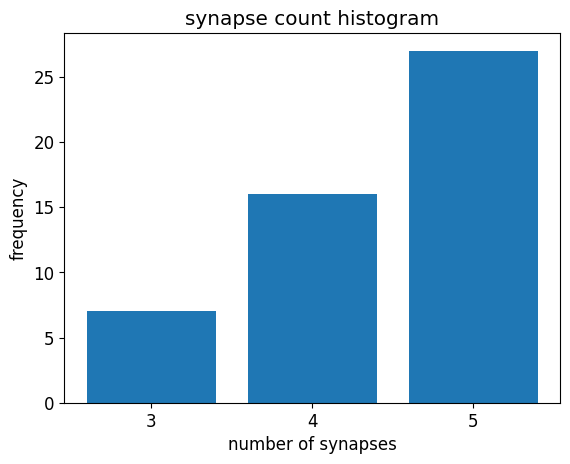

In [ ]:
from collections import Counter


def plot_synapse_count(model):
    # histogram of the number of synapses per neuron
    synapse_count = (model.ampli > 0).sum(axis=1).numpy()
    # Get counts
    counts = Counter(synapse_count)

    # Plot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("number of synapses")
    plt.ylabel("frequency")
    plt.title("synapse count histogram")
    plt.xticks(list(counts.keys()))
    plt.show()


plot_synapse_count(model)